In [1]:
# Instakart market basket analysis                  #Amaresh hiremani 22

# Import statements

import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

# Reading datasets from external csv file
print('loading product prior')
pprior = pd.read_csv('order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading product train')
ptrain = pd.read_csv('order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])
print('loaded completely')

/home/amaresh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading product prior
loading product train
loading orders
loading products
loaded completely


In [2]:
# Preprocessing 

#checking for any null values in orders dataframe
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [3]:
# Replacing the nan values with 0 (implies it is 1st order) day_prior_order in orders and converting to type int
# because as it is first order there are no previous order dates
value = 0
orders['days_since_prior_order']=orders['days_since_prior_order'].fillna(value)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int)
orders.isnull().sum()                                                #Amaresh hiremani 22

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [4]:
# Computing the user details (finding the details of purchase made by each user by user_id)

# Joining orders with product prior to get product id 
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
pprior = pprior.join(orders, on='order_id', rsuffix='_')
pprior.drop('order_id_', inplace=True, axis=1)

# Joining orders with product train to get product id 
print('add order info to train')
ptrain = ptrain.join(orders, on='order_id', rsuffix='_')
ptrain.drop('order_id_', inplace=True, axis=1)

# Reduce the user id to 500 to train 
limits = 500
ptrain = ptrain.loc[ptrain['user_id'] <= limits]

# Reduce the user id to 500 to test 
pprior = pprior.loc[pprior['user_id'] <= limits]

user = pd.DataFrame()

# Total number of order by users
user['total_products'] = pprior.groupby('user_id').size().astype(np.int16)

# All product_id of products purchased by users
user['products_all'] = pprior.groupby('user_id')['product_id'].apply(set)

# Distinct no of product user purchased
user['total_distinct_items'] = (user.products_all.map(len)).astype(np.int16)

# Finding average days between subsequent orders placed by same user from orders dataframe and no of orders
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

# Joining the user with usr by user_id
user = user.join(usr)
del usr
user['average_basket'] = (user.total_products / user.nb_orders).astype(np.float32)
print('number of users:', user.shape[0])

add order info to priors
add order info to train
number of users: 500


In [5]:
user.tail()

,total_products,products_all,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
496,452,"{47616, 47626, 9741, 49683, 31766, 48171, 3230...",108,3.373494,83,5.445783
497,160,"{38274, 47626, 23044, 42118, 41607, 5383, 3464...",75,10.700000,10,16.000000
498,134,"{23554, 39430, 47626, 22035, 15392, 40992, 123...",93,18.923077,13,10.307693
499,59,"{11136, 8193, 17794, 48130, 11520, 13829, 1703...",46,4.285714,7,8.428572
500,38,"{37509, 28296, 29064, 45194, 23819, 6029, 3458...",23,11.750000,4,9.500000


In [6]:
# Computing the products details 

print('computing product features')
prods = pd.DataFrame()
prods['orders'] = pprior.groupby(pprior.product_id).size().astype(np.int32)
prods['reorders'] = pprior['reordered'].groupby(pprior.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

computing product features


In [7]:
products.head()

,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,2.0,1.0,0.5
2,2,104,13,NaN,NaN,NaN
3,3,94,7,NaN,NaN,NaN
4,4,38,1,NaN,NaN,NaN
5,5,5,13,NaN,NaN,NaN


In [8]:
pprior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
333,40,10070,1,1,382,prior,29,1,15,23
334,40,42450,2,1,382,prior,29,1,15,23
335,40,33198,3,1,382,prior,29,1,15,23
336,40,34866,4,1,382,prior,29,1,15,23
14111,1483,32818,1,1,90,prior,31,3,13,5
14112,1483,27582,2,1,90,prior,31,3,13,5
14113,1483,12302,3,1,90,prior,31,3,13,5
14114,1483,1831,4,1,90,prior,31,3,13,5
14115,1483,19204,5,1,90,prior,31,3,13,5
14116,1483,10180,6,1,90,prior,31,3,13,5


In [9]:
# finding the total number of products
max_products = products['product_id'].max()
print('max product_id value :',max_products)
print('max of user_id :',limits)

max product_id value : 49688
max of user_id : 500


In [10]:
# Computing userXproduct details from user and product details previously obtained

print('compute userXproduct features this is long...')

# encoding the user_id and product_id into user_product because 50000 is the max value of product_id
pprior['user_product'] = pprior.product_id + pprior.user_id * 50000
d= dict()
for row in pprior.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,row.order_id,row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1, max(d[z][1], (row.order_id)),
                d[z][2] + row.add_to_cart_order)
        
print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

del pprior

compute userXproduct features this is long...
to dataframe (less memory)
user X product f 32233


In [11]:
userXproduct.head()

,nb_orders,last_order_id,sum_pos_in_cart
19110070,14,3417147,45
19142450,15,3391810,70
19133198,19,2353996,67
19134866,18,3076789,57
4532818,28,3247417,102


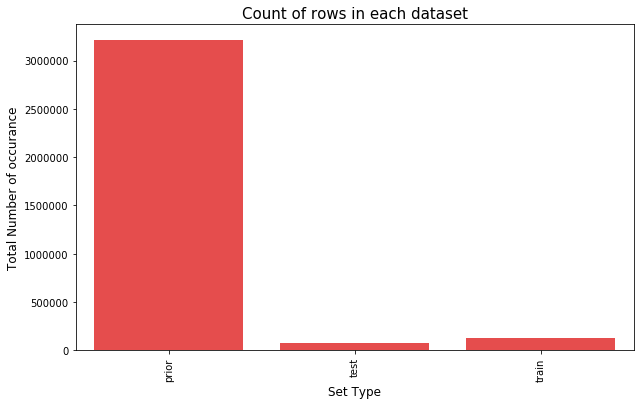

In [12]:
#different kind of evaluation set presrent in orders

count = orders.eval_set.value_counts()

plt.figure(figsize=(10,6))
sns.barplot(count.index, count.values, alpha=0.8, color='red')
plt.ylabel('Total Number of occurance', fontsize=12)
plt.xlabel('Set Type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show() 

In [24]:
# Seperation of train and test orderset from orders to make model and predict

print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

ptrain = ptrain[['order_id','product_id','add_to_cart_order','reordered']]
ptrain.set_index(['order_id', 'product_id'], inplace=True, drop=False)
train_orders = train_orders.loc[train_orders['user_id']<= limits]
test_orders = test_orders.loc[test_orders['user_id']<= limits]

split orders : train, test


In [33]:
### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%100 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = user.products_all[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in ptrain.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(user.nb_orders)
    df['user_total_items'] = df.user_id.map(user.total_products)
    df['total_distinct_items'] = df.user_id.map(user.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(user.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(user.average_basket)
    
    print('order related features')
    df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 50000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    return (df, labels)

In [38]:
# Gathering required features and labels for given train_orders 
train_x, train_y = features(train_orders, labels_given=True)

# Features used for training the model
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate','dow','UP_orders_since_last','UP_delta_hour_vs_last'] 

build candidate list
order row 100
order row 200
order row 300
user related features
order related features
product related features
user_X_product related features


In [35]:
# Building the models 
#1) lightgbm

# formating training data for light gbm 
train_xl = lgb.Dataset(train_x[f_to_use],
                      label=train_y,
                      categorical_feature=['aisle_id', 'department_id','dow','order_hour_of_day'],free_raw_data=False)

# Parameters used for light_gbm
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'learning_rate': 0.012,
    'max_depth': 10,
    'num_leaves': 98, 
    'objective':'binary',
    'metric':'binary_logloss',
    'feature_fraction': 0.92,
    'bagging_fraction': 0.98,
    'max_bin': 10}


# cross-validation
cv_result_lgb = lgb.cv(lgb_params, 
                       train_xl, 
                       num_boost_round=1000, 
                       nfold=10, 
                       stratified=True, 
                       early_stopping_rounds=60, 
                       verbose_eval=150, 
                       show_stdv=True)

# Calculating mean cross validation classification error
num_boost_rounds_lgb = len(cv_result_lgb['binary_logloss-mean'])
print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))
error_lgm = sum(cv_result_lgb['binary_logloss-mean'])
error_lgm = error_lgm/num_boost_rounds_lgb
print('mean error by cross validation',error_lgm*100)

# Training model with 100 rounds
rounds = 100
model_lgm = lgb.train(lgb_params, train_xl, rounds)
del train_xl

# Gathering required features for test_orders
test_x, _ = features(test_orders)

# Predicting 
preds =model_lgm.predict(test_x[f_to_use])
test_x['preds'] = preds

/home/amaresh/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[150]	cv_agg's binary_logloss: 0.296928 + 0.00582392
[300]	cv_agg's binary_logloss: 0.266518 + 0.0082247
[450]	cv_agg's binary_logloss: 0.265105 + 0.0102498
num_boost_rounds_lgb=407
mean error by cross validation 32.3451175325
build candidate list
order row 100
user related features
order related features
product related features
user_X_product related features


In [ ]:
xgdmat = xgb.DMatrix(train_x[f_to_use], train_y)
del train_x
del train_y

our_params = {'eta': 0.1, 'subsample': 0.76, 'colsample_bytree': 0.95,'eval_metric':'logloss','gamma':0.70,
             'objective': 'binary:logistic', 'max_depth':6, 'min_child_weight':10,'alpha':2e-05,'lambda':10} 

# Grid Search CV optimized settings

#cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 1000, nfold = 10,
#                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
#                early_stopping_rounds = 60) # Look for early stopping that minimizes error
#cv_xgb.tail()

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 100)
del xgdmat

# Gathering required features for test_orders
test_x, _ = features(test_orders)
testdmat = xgb.DMatrix(test_x[f_to_use])

y_pred = final_gb.predict(testdmat) # Predict using our testdmat
del testdmat

test_x['preds']=y_pred

In [40]:
xgdmat = xgb.DMatrix(train_x[f_to_use], train_y)
our_params = {'eta': 0.1, 'subsample': 0.76, 'colsample_bytree': 0.95,'eval_metric':'logloss','gamma':0.70,
             'objective': 'binary:logistic', 'max_depth':6, 'min_child_weight':10,'alpha':2e-05,'lambda':10} 
num_round = 2

print('running cross validation')
# do cross validation, this will print result out as
# [iteration]  metric_name:mean_value+std_value
# std_value is standard deviation of the metric
cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 1000, nfold = 10,
                metrics = ['error'],
                callbacks=[xgb.callback.print_evaluation(show_stdv=True)],
                early_stopping_rounds = 60)

running cross validation
[0]	train-error:0.0976373+0.000615248	test-error:0.101875+0.00548127
[1]	train-error:0.0969029+0.000690546	test-error:0.100296+0.00637152
[2]	train-error:0.0965355+0.000760602	test-error:0.100641+0.00496277
[3]	train-error:0.0966234+0.000618324	test-error:0.0993587+0.00485479
[4]	train-error:0.0964809+0.000589629	test-error:0.0991613+0.00495795
[5]	train-error:0.0963055+0.000686246	test-error:0.0989639+0.0052636
[6]	train-error:0.0962724+0.000817101	test-error:0.09852+0.00537292
[7]	train-error:0.0960806+0.000813404	test-error:0.0984213+0.00523593
[8]	train-error:0.0960314+0.000749801	test-error:0.0989639+0.00506576
[9]	train-error:0.09596+0.000849844	test-error:0.0985694+0.00467912
[10]	train-error:0.0957956+0.000746808	test-error:0.0984707+0.0050849
[11]	train-error:0.0954337+0.00059753	test-error:0.0986681+0.00494332
[12]	train-error:0.0952257+0.000729206	test-error:0.0990134+0.00484887
[13]	train-error:0.0950448+0.000621842	test-error:0.0988161+0.00504104
[

[117]	train-error:0.0805022+0.00116442	test-error:0.0969907+0.0050611
[118]	train-error:0.0803761+0.00119345	test-error:0.096744+0.00475974
[119]	train-error:0.080228+0.00113114	test-error:0.09704+0.0048034
[120]	train-error:0.08008+0.00107368	test-error:0.0968919+0.00470708
[121]	train-error:0.0800307+0.00104334	test-error:0.0969412+0.00444136
[122]	train-error:0.0798718+0.00101372	test-error:0.0969413+0.00443045
[123]	train-error:0.0796909+0.0010195	test-error:0.097336+0.00445128
[124]	train-error:0.0796362+0.00109767	test-error:0.0969906+0.00445208
[125]	train-error:0.0795647+0.000980649	test-error:0.0971387+0.00461981
[126]	train-error:0.0794771+0.000979092	test-error:0.0971879+0.00511724
[127]	train-error:0.0794058+0.000984094	test-error:0.0971387+0.00445868
[128]	train-error:0.0792414+0.000960869	test-error:0.0972375+0.00430898
[129]	train-error:0.0791318+0.00100132	test-error:0.0972374+0.00462496
[130]	train-error:0.0789782+0.00110738	test-error:0.0972867+0.004417
[131]	train-er

In [43]:
cv_xgb['total_error_mean']=cv_xgb['test-error-mean']+cv_xgb['train-error-mean']

In [45]:
cv_xgb['total_error_mean'].mean()

0.18661498319327735

In [83]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=6, early_stopping_rounds=60):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, predictors)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain,predictors,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(predictors, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(predictors, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9048
AUC Score (Train): 0.831313


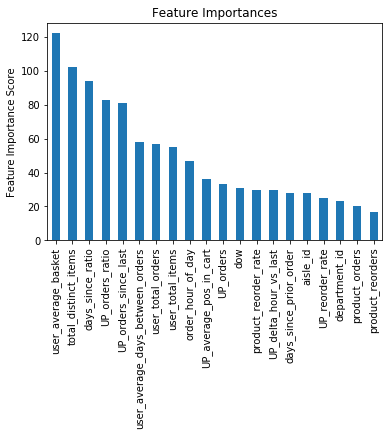

In [115]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=1,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1,train_x[f_to_use], train_y)

In [102]:
range1 = [1,2,3,4,5,6]
range2 = [4,6,8,10]
param_test1 = {
 'max_depth':range1,
 'min_child_weight':range2
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_x[f_to_use], train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.79863, std: 0.01924, params: {'max_depth': 1, 'min_child_weight': 4},
  mean: 0.79906, std: 0.01872, params: {'max_depth': 1, 'min_child_weight': 6},
  mean: 0.79911, std: 0.01842, params: {'max_depth': 1, 'min_child_weight': 8},
  mean: 0.79946, std: 0.01853, params: {'max_depth': 1, 'min_child_weight': 10},
  mean: 0.78585, std: 0.02403, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.79003, std: 0.02026, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.79106, std: 0.02041, params: {'max_depth': 2, 'min_child_weight': 8},
  mean: 0.79135, std: 0.01970, params: {'max_depth': 2, 'min_child_weight': 10},
  mean: 0.77398, std: 0.02810, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.77341, std: 0.02505, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.77650, std: 0.02355, params: {'max_depth': 3, 'min_child_weight': 8},
  mean: 0.77506, std: 0.02302, params: {'max_depth': 3, 'min_child_weight': 10},
  mean: 0.76053, std: 0.03275, params

In [103]:
range1 = [0,1,2]
range2 = [8,9,10,11,12]
param_test1 = {
 'max_depth':range1,
 'min_child_weight':range2
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_x[f_to_use], train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.50000, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 8},
  mean: 0.50000, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 9},
  mean: 0.50000, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 10},
  mean: 0.50000, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 11},
  mean: 0.50000, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 12},
  mean: 0.79911, std: 0.01842, params: {'max_depth': 1, 'min_child_weight': 8},
  mean: 0.79918, std: 0.01829, params: {'max_depth': 1, 'min_child_weight': 9},
  mean: 0.79946, std: 0.01853, params: {'max_depth': 1, 'min_child_weight': 10},
  mean: 0.79917, std: 0.01877, params: {'max_depth': 1, 'min_child_weight': 11},
  mean: 0.79975, std: 0.01818, params: {'max_depth': 1, 'min_child_weight': 12},
  mean: 0.79106, std: 0.02041, params: {'max_depth': 2, 'min_child_weight': 8},
  mean: 0.79137, std: 0.02056, params: {'max_depth': 2, 'min_child_weight': 9},
  mean: 0.79135, std: 0.01970, par

In [110]:
range1 = [2,4,6,8]
range2 = [4,6,8,10]
param_test1 = {
 'max_depth':range1,
 'min_child_weight':range2
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_x[f_to_use], train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.78585, std: 0.02403, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.79003, std: 0.02026, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.79106, std: 0.02041, params: {'max_depth': 2, 'min_child_weight': 8},
  mean: 0.79135, std: 0.01970, params: {'max_depth': 2, 'min_child_weight': 10},
  mean: 0.76053, std: 0.03275, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.76492, std: 0.02905, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.76594, std: 0.02907, params: {'max_depth': 4, 'min_child_weight': 8},
  mean: 0.76756, std: 0.02928, params: {'max_depth': 4, 'min_child_weight': 10},
  mean: 0.74624, std: 0.03159, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.74748, std: 0.02954, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: 0.74674, std: 0.03013, params: {'max_depth': 6, 'min_child_weight': 8},
  mean: 0.74806, std: 0.02950, params: {'max_depth': 6, 'min_child_weight': 10},
  mean: 0.73591, std: 0.03486, params

In [112]:
param_test3 = {
 'gamma':[0.1,0.2,0.3,0.4,0.5,0.6,0.7]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_x[f_to_use], train_y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.75014, std: 0.02937, params: {'gamma': 0.1},
  mean: 0.75381, std: 0.02883, params: {'gamma': 0.2},
  mean: 0.75005, std: 0.02991, params: {'gamma': 0.3},
  mean: 0.75120, std: 0.02741, params: {'gamma': 0.4},
  mean: 0.75267, std: 0.03039, params: {'gamma': 0.5},
  mean: 0.74849, std: 0.02988, params: {'gamma': 0.6},
  mean: 0.74832, std: 0.03019, params: {'gamma': 0.7}],
 {'gamma': 0.2},
 0.753813268000453)

In [113]:
param_test3 = {
 'gamma':[0.2,0.4,0.6,0.7,0.9]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_x[f_to_use], train_y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.75381, std: 0.02883, params: {'gamma': 0.2},
  mean: 0.75120, std: 0.02741, params: {'gamma': 0.4},
  mean: 0.74849, std: 0.02988, params: {'gamma': 0.6},
  mean: 0.74832, std: 0.03019, params: {'gamma': 0.7},
  mean: 0.75127, std: 0.02735, params: {'gamma': 0.9}],
 {'gamma': 0.2},
 0.753813268000453)


Model Report
Accuracy : 0.9183
AUC Score (Train): 0.903079


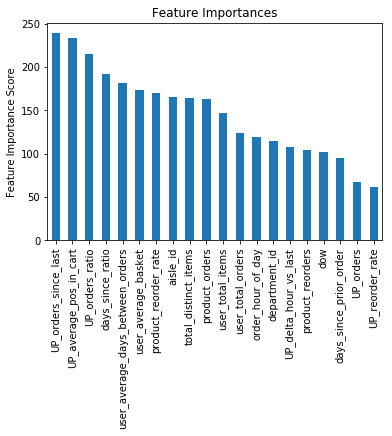

In [116]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=10,
 gamma=0.7,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train_x[f_to_use], train_y)